First we need to import all of our data.

In [242]:
import numpy as np
import pandas as pd
import os
import math
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Read in the data
conditionData = []
controlData = []
scores = pd.read_csv("data/scores.csv")

for fileName in os.listdir("data/condition"):
	conditionData.append(pd.read_csv(f"data/condition/{fileName}"))
for fileName in os.listdir(f"data/control"):
	controlData.append(pd.read_csv(f"data/control/{fileName}"))


Now we need to combine our motor activity in one file with the labels indicating if it is a condition or control

In [243]:

def findStartingPoint(startingPoint):
	# Find the first instance of the specified starttime to begin graphing our data
	beginIndex = 0
	c = 0
	for timestamp in data.timestamp:
		if timestamp.endswith(startingPoint):
			beginIndex = c
			break
		c += 1
	return beginIndex

timeStamp = "00:00:00"

# Raw data
df = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:]], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	df = pd.concat([df, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:]], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	df = pd.concat([df, dfTemp])


# Moving average for every 30 minutes
meandf = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(1801).mean().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	meandf = pd.concat([meandf, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(1801).mean().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	meandf = pd.concat([meandf, dfTemp])


# Moving median for every 30 minutes
mediandf = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(1801).median().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	mediandf = pd.concat([mediandf, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(1801).median().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	mediandf = pd.concat([mediandf, dfTemp])

First we will use a Random Forest Classifier to attempt classifying individuals with/without the condition. Because our samples are different lengths, we will need to fit our classifier only with datasets of equivalent size. We will build two functions, one where we trim the front of the data we use for training, and the other will trim the end of the data we use for training. The amount trimmed will be determined by the size of the testing data.

In [244]:
'''
x_train : Training data for our classifier
x_test  : Testing data for our classifier
y_train : Training labels for our classifier
y_test  : Testing labels for our classifier
numEst  : Number of estimators that our classifier will use
front   : Boolean to trim data from the front. False for end.
'''
def RandomForestAccuracy(x_train, x_test, y_train, y_test, numEst=10, front=True):
	clf=RandomForestClassifier(n_estimators=numEst)

	newXTest = []
	newYTest = []
	maxLength = len(np.array(x_test[0]))
	newXTest.append(np.array(x_test[0]))
	newYTest.append(y_test[0])

	# Find the first instance of the specified starttime to begin graphing our data

	newXTrain = []
	newYTrain = []
	for i in range(len(x_train)):
		itemCopy = np.array(x_train[i][0])
		if len(itemCopy) > maxLength:
			if front:
				itemCopy = itemCopy[:maxLength]
			else:
				itemCopy = itemCopy[-maxLength:]
		if len(itemCopy) == maxLength:
			newXTrain.append(itemCopy)
			newYTrain.append(y_train[i])
	newYTrain = np.array(newYTrain)
	newXTrain = np.array(newXTrain)

	accuracies = []
	numIters = 100
	# Sometimes there is no data we can use and our training set is empty, so we skip these trials.
	if len(newXTrain) > 0:
		for _ in range(numIters):
			clf.fit(newXTrain, newYTrain.ravel())
			accuracy = clf.score(newXTest, newYTest)
			accuracies.append(accuracy)

	return np.average(accuracies), maxLength

Find model accuracies using the moving average data.

In [245]:
y = meandf.iloc[:,-1:]
x = meandf.iloc[: ,-3:]

y = np.array(y)
x = np.array(x)

meanFrontTrimAccuracy = []
meanFrontTrimLength = []
meanEndTrimAccuracy = []
meanEndTrimLength = []
# Because our sample size is small, we need to do 'leave-one-out accuracy'. We will be making sure each sample is used as a testing sample at least once, and average each of those
# accuracies together.
for i in range(len(x)):
	x_test = x[i]
	y_test = y[i]
	x_train = np.delete(x, i, 0)
	y_train = np.delete(y, i, 0)

	# Trim from the front
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), front=True)
	if(not math.isnan(accuracy)):
		meanFrontTrimAccuracy.append(accuracy)
		meanFrontTrimLength.append(maxLength)
	
	# Trim from the end
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), front=False)
	if(not math.isnan(accuracy)):
		meanEndTrimAccuracy.append(accuracy)
		meanEndTrimLength.append(maxLength)

c:\Users\scrum\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\scrum\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot our data so that we can visualize our findings.

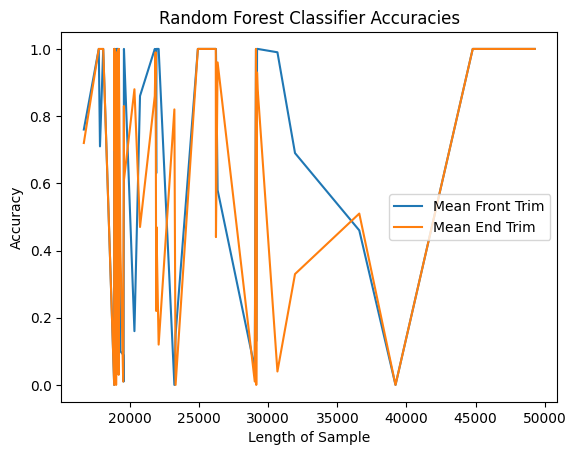

In [246]:

meanFrontList = list(zip(meanFrontTrimLength, meanFrontTrimAccuracy))
sortedMeanFrontList = sorted(meanFrontList, key=lambda x: x[0])
sortedMeanFrontX, sortedMeanFrontY = zip(*sortedMeanFrontList)

meanEndList = list(zip(meanEndTrimLength, meanEndTrimAccuracy))
sortedMeanEndList = sorted(meanEndList, key=lambda x: x[0])
sortedMeanEndX, sortedMeanEndY = zip(*sortedMeanEndList)

plt.plot(sortedMeanFrontX, sortedMeanFrontY, label="Mean Front Trim")
plt.plot(sortedMeanEndX, sortedMeanEndY, label="Mean End Trim")
plt.title("Random Forest Classifier Accuracies")
plt.xlabel("Length of Sample")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Now we will do the same Random Forest Classification, but this time with a moving median dataset.

In [247]:
y = mediandf.iloc[:,-1:]
x = mediandf.iloc[: ,-3:]

y = np.array(y)
x = np.array(x)

medianFrontTrimAccuracy = []
medianFrontTrimLength = []
medianEndTrimAccuracy = []
medianEndTrimLength = []
# Because our sample size is small, we need to do 'leave-one-out accuracy'. We will be making sure each sample is used as a testing sample at least once, and average each of those
# accuracies together.
for i in range(len(x)):
	x_test = x[i]
	y_test = y[i]
	x_train = np.delete(x, i, 0)
	y_train = np.delete(y, i, 0)

	# Trim from the front
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), front=True)
	if(not math.isnan(accuracy)):
		medianFrontTrimAccuracy.append(accuracy)
		medianFrontTrimLength.append(maxLength)
	
	# Trim from the end
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), front=False)
	if(not math.isnan(accuracy)):
		medianEndTrimAccuracy.append(accuracy)
		medianEndTrimLength.append(maxLength)

c:\Users\scrum\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\scrum\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot our data so that we can visualize our findings.

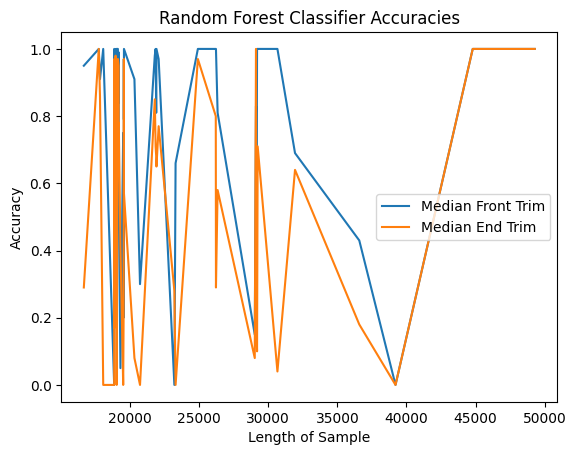

In [248]:
medianFrontList = list(zip(medianFrontTrimLength, medianFrontTrimAccuracy))
sortedMedianFrontList = sorted(medianFrontList, key=lambda x: x[0])
sortedMedianFrontX, sortedMedianFrontY = zip(*sortedMedianFrontList)

medianEndList = list(zip(medianEndTrimLength, medianEndTrimAccuracy))
sortedMedianEndList = sorted(medianEndList, key=lambda x: x[0])
sortedMedianEndX, sortedMedianEndY = zip(*sortedMedianEndList)

plt.plot(sortedMedianFrontX, sortedMedianFrontY, label="Median Front Trim")
plt.plot(sortedMedianEndX, sortedMedianEndY, label="Median End Trim")
plt.title("Random Forest Classifier Accuracies")
plt.xlabel("Length of Sample")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

By comparing the two accuracy graphs, we can see that our lengths are condensed around the 15000-30000 range. On the Moving average graph, there seems to be little consequence in trimming from the front or from the back. This makes sense, as we don't have many outliers so a moving average would be more beneficial. If we look at our moving median graph directly above, we see more of a split from our front trimming vs end trimming. Namely, on the first datapoint. This is important, as our first datapoint references our data with the smallest length. Because it is the smallest in length, it means that all other samples were used in the training (as they all could be trimmed to the correct size) and therefore this represents our best fitting. Using a Median End Trim is the worst possible data mine.

Now, you might be wondering "Why training on all lengths if the shortest was going to be the best anyway?" Well, we didn't know that the shortest would be best, so we tried all lengths just in case the shortest length was an outlier and would not be fit for testing. But we are pleased to say that using the shortest length appears to be the best strategy. We will display a graph of the shortest length combinations below:

In [249]:
print(tabulate([['Mean Front', sortedMeanFrontY[0]], 
['Mean End', sortedMeanEndY[0]], 
['Median Front', sortedMedianFrontY[0]], 
['Median End', sortedMedianEndY[0]]], headers=['Mine Type', 'Accuracy']))

Mine Type       Accuracy
------------  ----------
Mean Front          0.76
Mean End            0.72
Median Front        0.95
Median End          0.29


Why is median front trimming the best? I have no idea and we should explore this more.

### Showing a person's daily activity:

What does the activity of a person look like over the time they participated in the experiment? We can pretty easily tell from the graphs below the times that a person was asleep. These times are characterized by log periods of really low activity levels. Additionally we can see peaks of activity that could show when a person exercised.

C:\Users\scrum\AppData\Local\Temp\ipykernel_11676\3880695398.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df.TimeStamp.tolist()[person][beginIndex : beginIndex+(60*hours_to_display)], df.Activity.tolist()[person][beginIndex: beginIndex + (60*hours_to_display)])


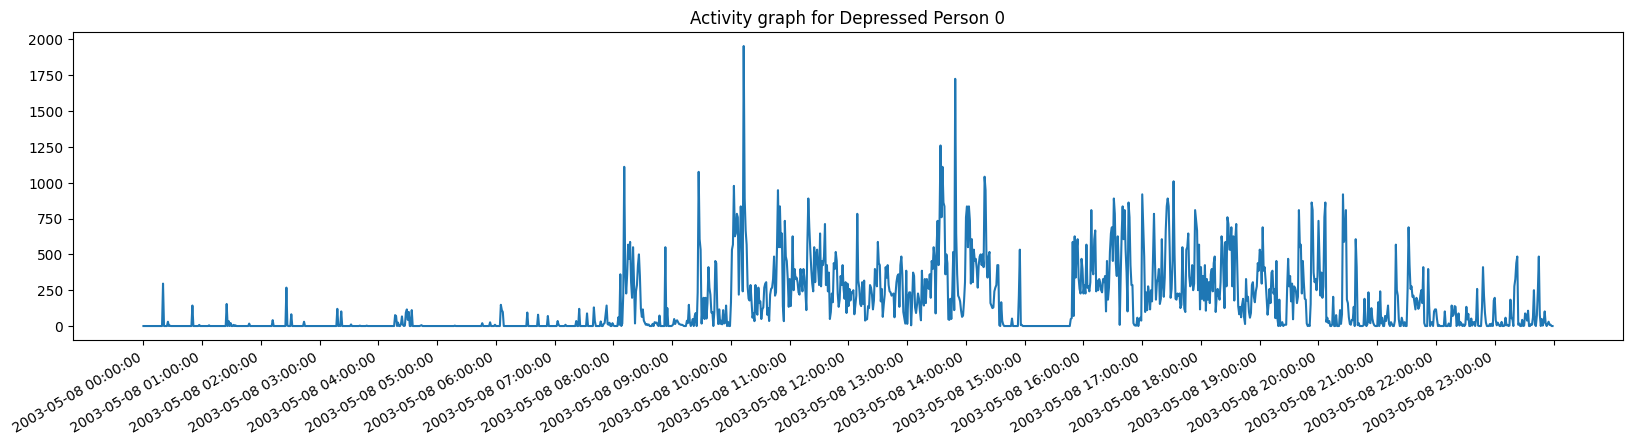

C:\Users\scrum\AppData\Local\Temp\ipykernel_11676\3880695398.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df.TimeStamp.tolist()[person][beginIndex : beginIndex+(60*hours_to_display)], df.Activity.tolist()[person][beginIndex: beginIndex + (60*hours_to_display)])


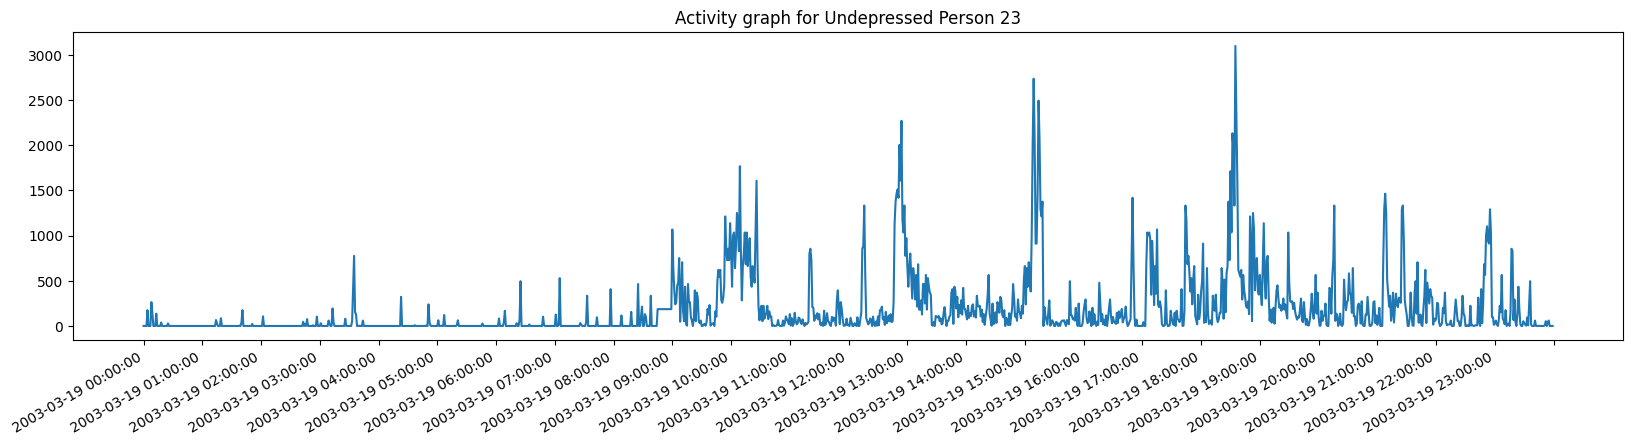

In [250]:

from datetime import datetime

def graph_person_activity(person, hours_to_display=24, start_time_str=""):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(4)

    # Find the first instance of the specified starttime to begin graphing our data
    beginIndex = 0
    if start_time_str != "":
        c = 0
        for timestamp in df.TimeStamp.tolist()[person]:
            if timestamp.endswith(start_time_str):
                beginIndex = c
                break
            c += 1
        if c >= len(df.TimeStamp.tolist()[person]):
            print("Error: Could not find specified Start Time: " + start_time_str)
            print("Defaulting to beginning of test data")
    
    # Display the activity of the person in our Datase for the number of hours selected beginning at the first applicable start time.
    plt.title(f"Activity graph for Depressed Person {person}" if df.Target.tolist()[person] == 'condition' else f"Activity graph for Undepressed Person {person}")
    plt.plot(df.TimeStamp.tolist()[person][beginIndex : beginIndex+(60*hours_to_display)], df.Activity.tolist()[person][beginIndex: beginIndex + (60*hours_to_display)])
    plt.xticks(np.arange(0, (60*hours_to_display)+ 1, 60), rotation=30, ha='right') # set xticks to every hour instead of every minute
    plt.show()


# Graph activity for first Depressed individual
graph_person_activity(0, 24, "00:00:00")
# Graph Activity for first Control individual
graph_person_activity(23, 24, "00:00:00")


### Exercise and Classifying Depression

Scientists have said that getting 30 minutes of Exercise each day is beneficial to mental health. We can get the sum of the highest consecutive 30 minutes every day to determine an 'Exercise Score' for each person each day they participated in the experiment.

In [251]:
# take a persons total activity log and split into "days" or 24 hours
# find max sum of 30 consecutive minutes and put that as a time series value. 
import math


exerciseScores = []
for person in df.Activity.tolist():
    personScores = []
    dayCount = len(person)//(24*60)
    for i in range(0, dayCount): # for each day the person participated
        maxActivity = -1
        startOfDay = i * (24*60)
        endOfDay = min(i * (24*60) + (24*60), len(person)-1)
        for j in range(startOfDay, endOfDay- 30): # for each minute in the specific day. (except the last 30 minutes)
            score = sum(person[j : j+30]) # Get the sum of the activity for the 30 minutes
            if score > maxActivity: # if this is the max then save it as the max
                maxActivity = score
        personScores.append(maxActivity) # append Score to person scores
    
    exerciseScores.append(personScores) # append each person's score TS to the exercise scores

# Clean up exercise scores by removing bad data. (Any data where the max activity for the entire day was less than 1000) 
# The reason we would get anything less than 1000 is if the person did not move at all through the whole day, or they 
# had a bad sensor.
for p in exerciseScores:
    trash = []
    for s in p:
        if s <= 1000:
            trash.append(s)
    for t in trash:
        p.remove(t)

minlen = min(len(i) for i in exerciseScores)
# create a TS with mean, std, min, and max to make each have the same length
exerciseStats = []
for person in exerciseScores:
	temp = [np.average(person), np.std(person), min(person), max(person)]
	exerciseStats.append(temp)
    


C:\Users\scrum\AppData\Local\Temp\ipykernel_11676\3986168623.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score = sum(person[j : j+30]) # Get the sum of the activity for the 30 minutes


In [252]:
y = np.array(y)
x = np.array(exerciseStats)

a = []
for _ in range(100):
	sss = StratifiedShuffleSplit(n_splits=1, test_size=0.02)
	sss.get_n_splits(x, y)
	for train_index, test_index in sss.split(x, y):
		X_train, X_test = x[train_index], x[test_index]
		y_train, y_test = y[train_index], y[test_index]

	clf=RandomForestClassifier(n_estimators=10)
	clf.fit(X_train, y_train.ravel())
	accuracy = clf.score(X_test, y_test)
	a.append(accuracy)
print("Average Accuracy:", np.average(a))

Average Accuracy: 0.545


Once again we see that we are getting an average classification accuracy of around 64-68%. This likely points out that exercising daily does not have too strong of a coorelation with depression. One can choose to not exercise and not be depressed.

### Sedentary Lifestyle and Depression

Experts say that depressed patients often live sedentary lifestyles where they will not be active during the day. We can see this from a low number count over the time of day. We will use 10 as the threshold for our 'low number'.

### Sleep and Classifying Depression

Experts have said getting 8 hours of restful sleep is essential to good mental health. We can give a rested score of the longest length of low activity for each day. Threshold for low activity will be 10. 